In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=[
        "#4B9AC7",
        "#4BE8E0",
        "#9DD4F3",
        "#97FBF6",
        "#2A7FAF",
        "#23B1AB",
        "#0E3449",
        "#015955",
    ]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

In [22]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Data.csv")
print("Dataset loaded successfully.")
print(f"Shape of dataset: {dataset.shape}")
print("First 5 rows:")
print(dataset.head())
print()

Loading dataset...
Dataset loaded successfully.
Shape of dataset: (10, 4)
First 5 rows:
   Country   Age  Salary Purchased
0   France  44.0   72000        No
1    Spain  27.0   48000       Yes
2  Germany  30.0   54000        No
3    Spain  38.0   61000        No
4  Germany  40.0   69000       Yes



In [23]:
# Basic statistics and dataset overview
print("Dataset Overview:")
print(f"Number of rows: {dataset.shape[0]}")
print(f"Number of columns: {dataset.shape[1]}")
print()

# Display first few rows of the dataset
print("Preview of the dataset:")
display(dataset.head())
print()

# Basic statistics
print("Basic statistics for numerical and categorical columns:")
data_desc = dataset.describe(include="all")
display(data_desc)
print()

# Percentage of missing values for each column
print("Percentage of missing values in each column:")
missing_values = 100 * dataset.isnull().sum() / dataset.shape[0]
display(missing_values)

Dataset Overview:
Number of rows: 10
Number of columns: 4

Preview of the dataset:


,Country,Age,Salary,Purchased
0,France,44.0,72000,No
1,Spain,27.0,48000,Yes
2,Germany,30.0,54000,No
3,Spain,38.0,61000,No
4,Germany,40.0,69000,Yes



Basic statistics for numerical and categorical columns:


,Country,Age,Salary,Purchased
count,10,9.000000,10.000000,10
unique,3,NaN,NaN,2
top,France,NaN,NaN,No
freq,4,NaN,NaN,5
mean,NaN,38.777778,64300.000000,NaN
std,NaN,7.693793,11681.419244,NaN
min,NaN,27.000000,48000.000000,NaN
25%,NaN,35.000000,55000.000000,NaN
50%,NaN,38.000000,64000.000000,NaN
75%,NaN,44.000000,71250.000000,NaN



Percentage of missing values in each column:


Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64

# Preprocessing

In [24]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Purchased"

X = dataset.drop(columns=[target_variable])
Y = dataset[target_variable]

print("...Done.")
print()

print("Y (Target variable):")
print(Y.head())
print("\nX (Features):")
print(X.head())

Separating labels from features...
...Done.

Y (Target variable):
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X (Features):
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [25]:
# Automatically detect names of numeric and categorical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

print("Found numeric features:", numeric_features)
print("Found categorical features:", categorical_features)

Found numeric features: ['Age', 'Salary']
Found categorical features: ['Country']


In [26]:
# Divide dataset into Train and Test sets
print("Dividing dataset into train and test sets...")
# Using stratify=Y to ensure balanced class distribution in both sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, stratify=Y
)
print("Dataset division complete.")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print()

Dividing dataset into train and test sets...
Dataset division complete.
Training set size: 8 samples
Test set size: 2 samples



TIP No need to normalize the numeric features!

Decision trees are not sensitive at all to the scale of the input features. So, if you plan to use only decision-tree-based algorithms, you can just skip the standardization step! The model's convergence time won't be deteriorated, neither will the computation of the features' importances.

In [27]:
# Pipeline for processing numeric features
numeric_transformer = Pipeline(steps=[
    ("mean_imputer", SimpleImputer(strategy="mean"))  # Remplace les valeurs manquantes par la moyenne des colonnes
])

In [28]:
# Pipeline for processing categorical features
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first"))  # Encode variables as dummy variables, dropping the first level
])

In [29]:
# Define a ColumnTransformer to preprocess both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [30]:
# Preprocessings on training set
print("Performing preprocessing on training set...")
print("First 5 rows before preprocessing:")
print(X_train.head())

X_train = preprocessor.fit_transform(X_train)
print("Preprocessing complete.")
print("First 5 rows after preprocessing:")
print(X_train[:5])  # Utilisation de la syntaxe numpy car X_train est maintenant un numpy array
print()

# Label encoding for Y_train
print("Encoding labels for training set...")
print("Original labels (first 5):")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("Encoded labels (first 5):")
print(Y_train[:5])
print("...Done\n")

# Preprocessings on test set
print("Performing preprocessing on test set...")
print("First 5 rows before preprocessing:")
print(X_test.head())

# Only transform on the test set, no fitting
X_test = preprocessor.transform(X_test)
print("Preprocessing complete.")
print("First 5 rows after preprocessing:")
print(X_test[:5, :])
print()

# Label encoding for Y_test
print("Encoding labels for test set...")
print("Original labels (first 5):")
print(Y_test.head())
Y_test = encoder.transform(Y_test)
print("Encoded labels (first 5):")
print(Y_test[:5])
print("...Done")

Performing preprocessing on training set...
First 5 rows before preprocessing:
   Country   Age  Salary
0   France  44.0   72000
4  Germany  40.0   69000
6    Spain   NaN   52000
9   France  37.0   67000
3    Spain  38.0   61000
Preprocessing complete.
First 5 rows after preprocessing:
[[4.40000000e+01 7.20000000e+04 0.00000000e+00 0.00000000e+00]
 [4.00000000e+01 6.90000000e+04 1.00000000e+00 0.00000000e+00]
 [3.58571429e+01 5.20000000e+04 0.00000000e+00 1.00000000e+00]
 [3.70000000e+01 6.70000000e+04 0.00000000e+00 0.00000000e+00]
 [3.80000000e+01 6.10000000e+04 0.00000000e+00 1.00000000e+00]]

Encoding labels for training set...
Original labels (first 5):
0     No
4    Yes
6     No
9    Yes
3     No
Name: Purchased, dtype: object
Encoded labels (first 5):
[0 1 0 1 0]
...Done

Performing preprocessing on test set...
First 5 rows before preprocessing:
   Country   Age  Salary
8  Germany  50.0   83000
7   France  48.0   79000
Preprocessing complete.
First 5 rows after preprocessing:
[[

# Decision tree

Let's train a decision tree (with hyperparameter optimization) and evaluate its performances :

Training with hyperparameter optimization
    
For Decision trees, the hyperparameters that are important for overfitting are :

min_samples_leaf

min_samples_split

max_depth

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [31]:
# Initialisation du classifieur
classifier = DecisionTreeClassifier()

# Grille des hyperparamètres à tester
param_grid = {
    "max_depth": [4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8],
}

# Configuration et exécution du Grid Search avec suivi de progression
print("Performing grid search...")
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=3,  # Nombre de plis pour la validation croisée
#    verbose=2,  # Affiche la progression pour chaque combinaison d'hyperparamètres
#    n_jobs=-1,  # Utilise tous les cœurs disponibles pour accélérer le calcul
)

# Entraînement du modèle avec la recherche des meilleurs hyperparamètres
grid_search.fit(X_train, Y_train)
print("...Grid search complete.")

# Affichage des meilleurs hyperparamètres et de la meilleure performance
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Performing grid search...
...Grid search complete.
Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation accuracy: 0.5000


Performances

In [32]:
# Prédictions sur l'ensemble d'entraînement
print("Making predictions on training set...")
Y_train_pred = grid_search.predict(X_train)
print("Predictions completed.")
print("Training set predictions:", Y_train_pred)
print()

# Estimation des probabilités sur l'ensemble d'entraînement
print("Calculating probabilities on training set...")
Y_train_proba = grid_search.predict_proba(X_train)
print("Probability estimation completed.")
print("Training set probabilities:")
print(Y_train_proba)
print()

Making predictions on training set...
Predictions completed.
Training set predictions: [1 1 0 1 0 1 1 1]

Calculating probabilities on training set...
Probability estimation completed.
Training set probabilities:
[[0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [1.         0.        ]
 [0.33333333 0.66666667]
 [1.         0.        ]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]
 [0.33333333 0.66666667]]



In [33]:
# Prédictions sur l'ensemble de test
print("Making predictions on test set...")
Y_test_pred = grid_search.predict(X_test)
print("Predictions on test set completed.")
print("Test set predictions:", Y_test_pred)
print()

# Estimation des probabilités sur l'ensemble de test
print("Calculating probabilities on test set...")
Y_test_proba = grid_search.predict_proba(X_test)
print("Probability estimation on test set completed.")
print("Test set probabilities:")
print(Y_test_proba)
print()

Making predictions on test set...
Predictions on test set completed.
Test set predictions: [1 1]

Calculating probabilities on test set...
Probability estimation on test set completed.
Test set probabilities:
[[0.33333333 0.66666667]
 [0.33333333 0.66666667]]



In [34]:
# Affichage des scores
print(f"Accuracy on training set: {accuracy_score(Y_train, Y_train_pred):.4f}")
print(f"Accuracy on test set: {accuracy_score(Y_test, Y_test_pred):.4f}")
print()

print(f"F1-score on training set: {f1_score(Y_train, Y_train_pred):.4f}")
print(f"F1-score on test set: {f1_score(Y_test, Y_test_pred):.4f}")
print()

Accuracy on training set: 0.7500
Accuracy on test set: 0.5000

F1-score on training set: 0.8000
F1-score on test set: 0.6667



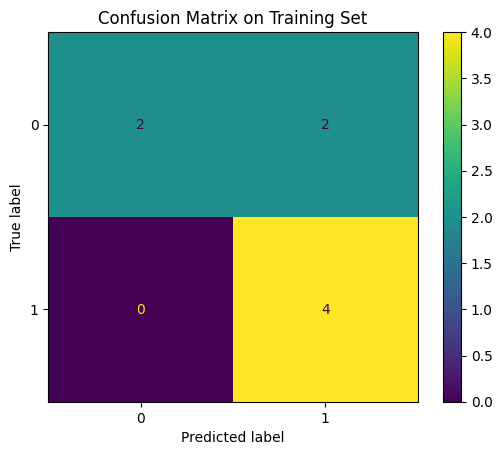

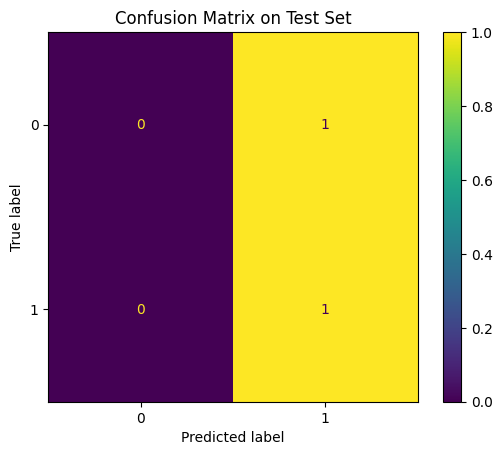

In [35]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(model, X, Y, title):
    _, ax = plt.subplots()
    ax.set(title=title)
    ConfusionMatrixDisplay.from_estimator(model, X, Y, ax=ax)
    plt.show()

# Visualisation des matrices de confusion
plot_confusion_matrix(grid_search, X_train, Y_train, "Confusion Matrix on Training Set")
plot_confusion_matrix(grid_search, X_test, Y_test, "Confusion Matrix on Test Set")

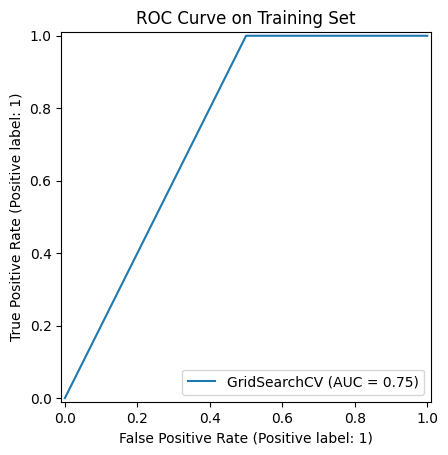

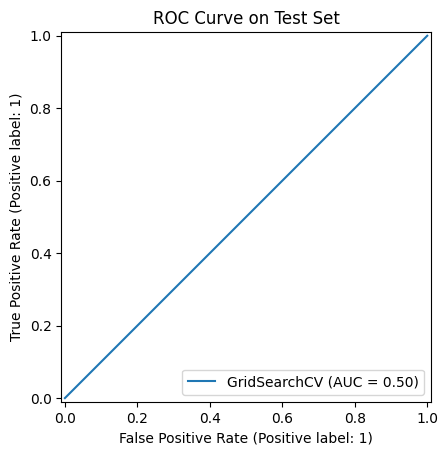

In [36]:
# Fonction pour afficher la courbe ROC
def plot_roc_curve(model, X, Y, title):
    _, ax = plt.subplots()
    ax.set(title=title)
    RocCurveDisplay.from_estimator(model, X, Y, ax=ax)
    plt.show()

# Visualisation des courbes ROC
plot_roc_curve(grid_search, X_train, Y_train, "ROC Curve on Training Set")
plot_roc_curve(grid_search, X_test, Y_test, "ROC Curve on Test Set")

# Random Forest

Let's train a Random Forest (with hyperparameter optimization) and evaluate its performances :

Training with hyperparameter optimization
For Random Forest, the hyperparameters that are important for overfitting are :

min_samples_leaf

min_samples_split

max_depth

n_estimators

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [39]:
# Initialisation du classifieur
classifier = RandomForestClassifier()

# Grille des hyperparamètres à tester
param_grid = {
    "max_depth": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8],
    "n_estimators": [10, 20, 40, 60, 80, 100],
}

# Configuration et exécution du Grid Search avec suivi de progression
print("Performing grid search...")
grid_search = GridSearchCV(
    estimator=classifier,
    param_grid=param_grid,
    cv=3,  # Nombre de plis pour la validation croisée
    verbose=2,  # Affiche la progression pour chaque combinaison d'hyperparamètres
    n_jobs=-1,  # Utilise tous les cœurs disponibles pour accélérer le calcul
)

# Entraînement du modèle avec la recherche des meilleurs hyperparamètres
grid_search.fit(X_train, Y_train)
print("...Grid search complete.")

# Affichage des meilleurs hyperparamètres et de la meilleure performance
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Performing grid search...
Fitting 3 folds for each of 270 candidates, totalling 810 fits
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=40; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=20; total time=   0.0s
[CV] END max_depth=2, min_samples_leaf=1, min_samples_split=2, n_estimators=60; total time=   0.0s
[CV] END max_depth=2

Performances

In [40]:
# Prédictions sur l'ensemble d'entraînement
print("Making predictions on training set...")
Y_train_pred = grid_search.predict(X_train)
print("Predictions completed.")
print("Training set predictions:", Y_train_pred)
print()

# Estimation des probabilités sur l'ensemble d'entraînement
print("Calculating probabilities on training set...")
Y_train_proba = grid_search.predict_proba(X_train)
print("Probability estimation completed.")
print("Training set probabilities:")
print(Y_train_proba)
print()

Making predictions on training set...
Predictions completed.
Training set predictions: [0 1 0 1 0 1 0 1]

Calculating probabilities on training set...
Probability estimation completed.
Training set probabilities:
[[0.61770833 0.38229167]
 [0.29666667 0.70333333]
 [0.70854167 0.29145833]
 [0.246875   0.753125  ]
 [0.68604167 0.31395833]
 [0.371875   0.628125  ]
 [0.60833333 0.39166667]
 [0.34       0.66      ]]



In [41]:
# Prédictions sur l'ensemble de test
print("Making predictions on test set...")
Y_test_pred = grid_search.predict(X_test)
print("Predictions on test set completed.")
print("Test set predictions:")
print(Y_test_pred)
print()

# Estimation des probabilités sur l'ensemble de test
print("Calculating probabilities on test set...")
Y_test_proba = grid_search.predict_proba(X_test)
print("Probability estimation on test set completed.")
print("Test set probabilities:")
print(Y_test_proba)
print()

Making predictions on test set...
Predictions on test set completed.
Test set predictions:
[0 0]

Calculating probabilities on test set...
Probability estimation on test set completed.
Test set probabilities:
[[0.55604167 0.44395833]
 [0.61770833 0.38229167]]



In [42]:
# Affichage des scores
print(f"Accuracy on training set: {accuracy_score(Y_train, Y_train_pred):.4f}")
print(f"Accuracy on test set: {accuracy_score(Y_test, Y_test_pred):.4f}")
print()

print(f"F1-score on training set: {f1_score(Y_train, Y_train_pred):.4f}")
print(f"F1-score on test set: {f1_score(Y_test, Y_test_pred):.4f}")
print()

Accuracy on training set: 1.0000
Accuracy on test set: 0.5000

F1-score on training set: 1.0000
F1-score on test set: 0.0000



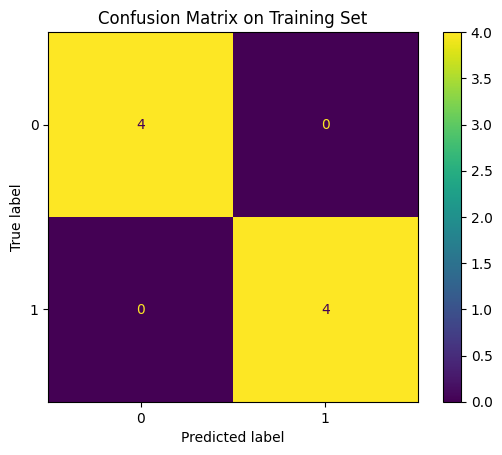

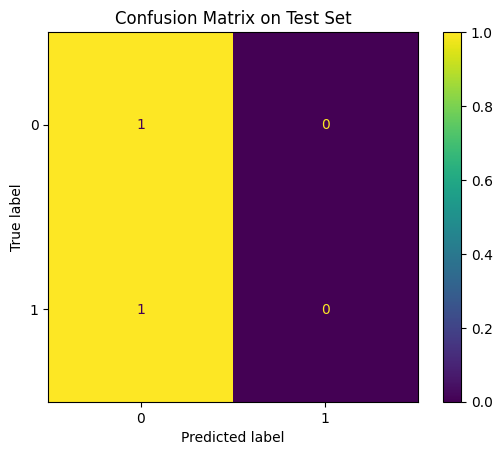

In [44]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(model, X, Y, title):
    _, ax = plt.subplots()
    ax.set(title=title)
    ConfusionMatrixDisplay.from_estimator(model, X, Y, ax=ax)
    plt.show()

# Visualisation des matrices de confusion
plot_confusion_matrix(grid_search, X_train, Y_train, "Confusion Matrix on Training Set")
plot_confusion_matrix(grid_search, X_test, Y_test, "Confusion Matrix on Test Set")

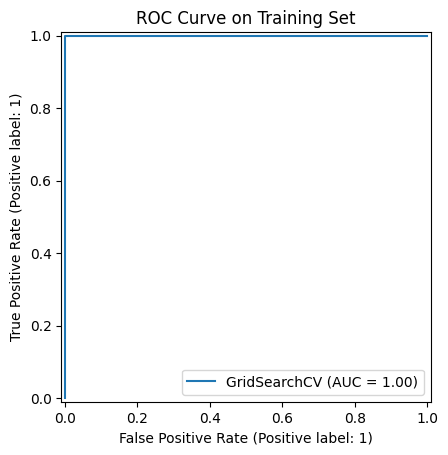

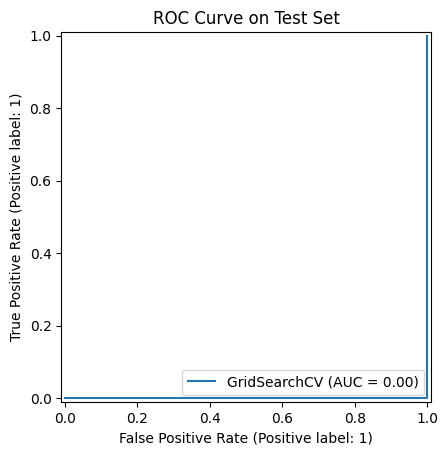

In [43]:
# Fonction pour afficher la courbe ROC
def plot_roc_curve(model, X, Y, title):
    _, ax = plt.subplots()
    ax.set(title=title)
    RocCurveDisplay.from_estimator(model, X, Y, ax=ax)
    plt.show()

# Visualisation des courbes ROC
plot_roc_curve(grid_search, X_train, Y_train, "ROC Curve on Training Set")
plot_roc_curve(grid_search, X_test, Y_test, "ROC Curve on Test Set")

# Feature importance

All the classes from the module sklearn.tree have an attribute named feature_importances_ that allows to get a ranking of the features once the model has been trained. Let's see an example of how to interpret these values obtained with the best RandomForestClassifier:

In [45]:
column_names = []
for name, step, features_list in preprocessor.transformers_:  # boucle sur les étapes du ColumnTransformer
    if name == "num":  # pour les variables numériques
        features = features_list  # noms des colonnes d'origine
    else:  # pour les variables catégorielles
        features = step.get_feature_names_out(features_list)  # noms des colonnes générées par OneHotEncoder
    column_names.extend(features)  # ajoute les noms des colonnes transformées

print("Names of columns corresponding to each coefficient:", column_names)

Names of columns corresponding to each coefficient: ['Age', 'Salary', 'Country_Germany', 'Country_Spain']


In [48]:
# Accéder au meilleur modèle trouvé par GridSearchCV
best_model = grid_search.best_estimator_

# Extraire les importances des caractéristiques
feature_importances = best_model.feature_importances_

# Associer les noms des colonnes aux importances
feature_importance_df = pd.DataFrame({
    "Feature": column_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Affichage des importances
print("Feature importances for the best RandomForestClassifier model:")
print(feature_importance_df)

Feature importances for the best RandomForestClassifier model:
           Feature  Importance
0              Age    0.474012
1           Salary    0.315812
3    Country_Spain    0.109549
2  Country_Germany    0.100628


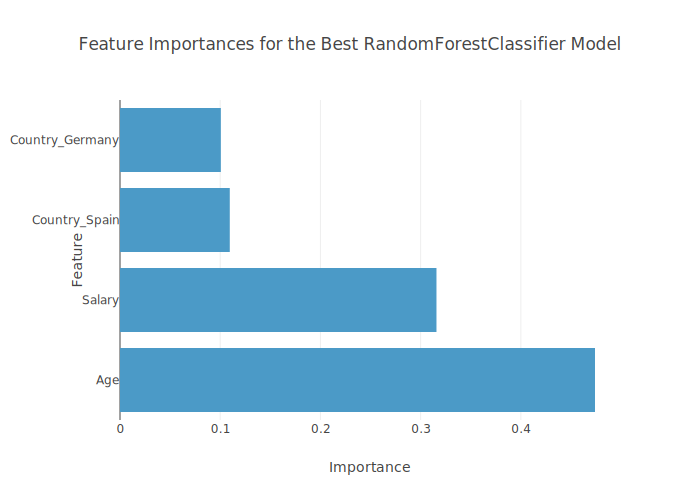

In [49]:
# Tracer les importances des caractéristiques
fig = px.bar(
    feature_importance_df,
    x="Importance",
    y="Feature",
    orientation="h",
    title="Feature Importances for the Best RandomForestClassifier Model"
)

fig.update_layout(
    showlegend=False,
    margin={"l": 120}  # pour éviter que les noms de colonnes soient coupés
)
fig.show()